### Fintech AI Agent

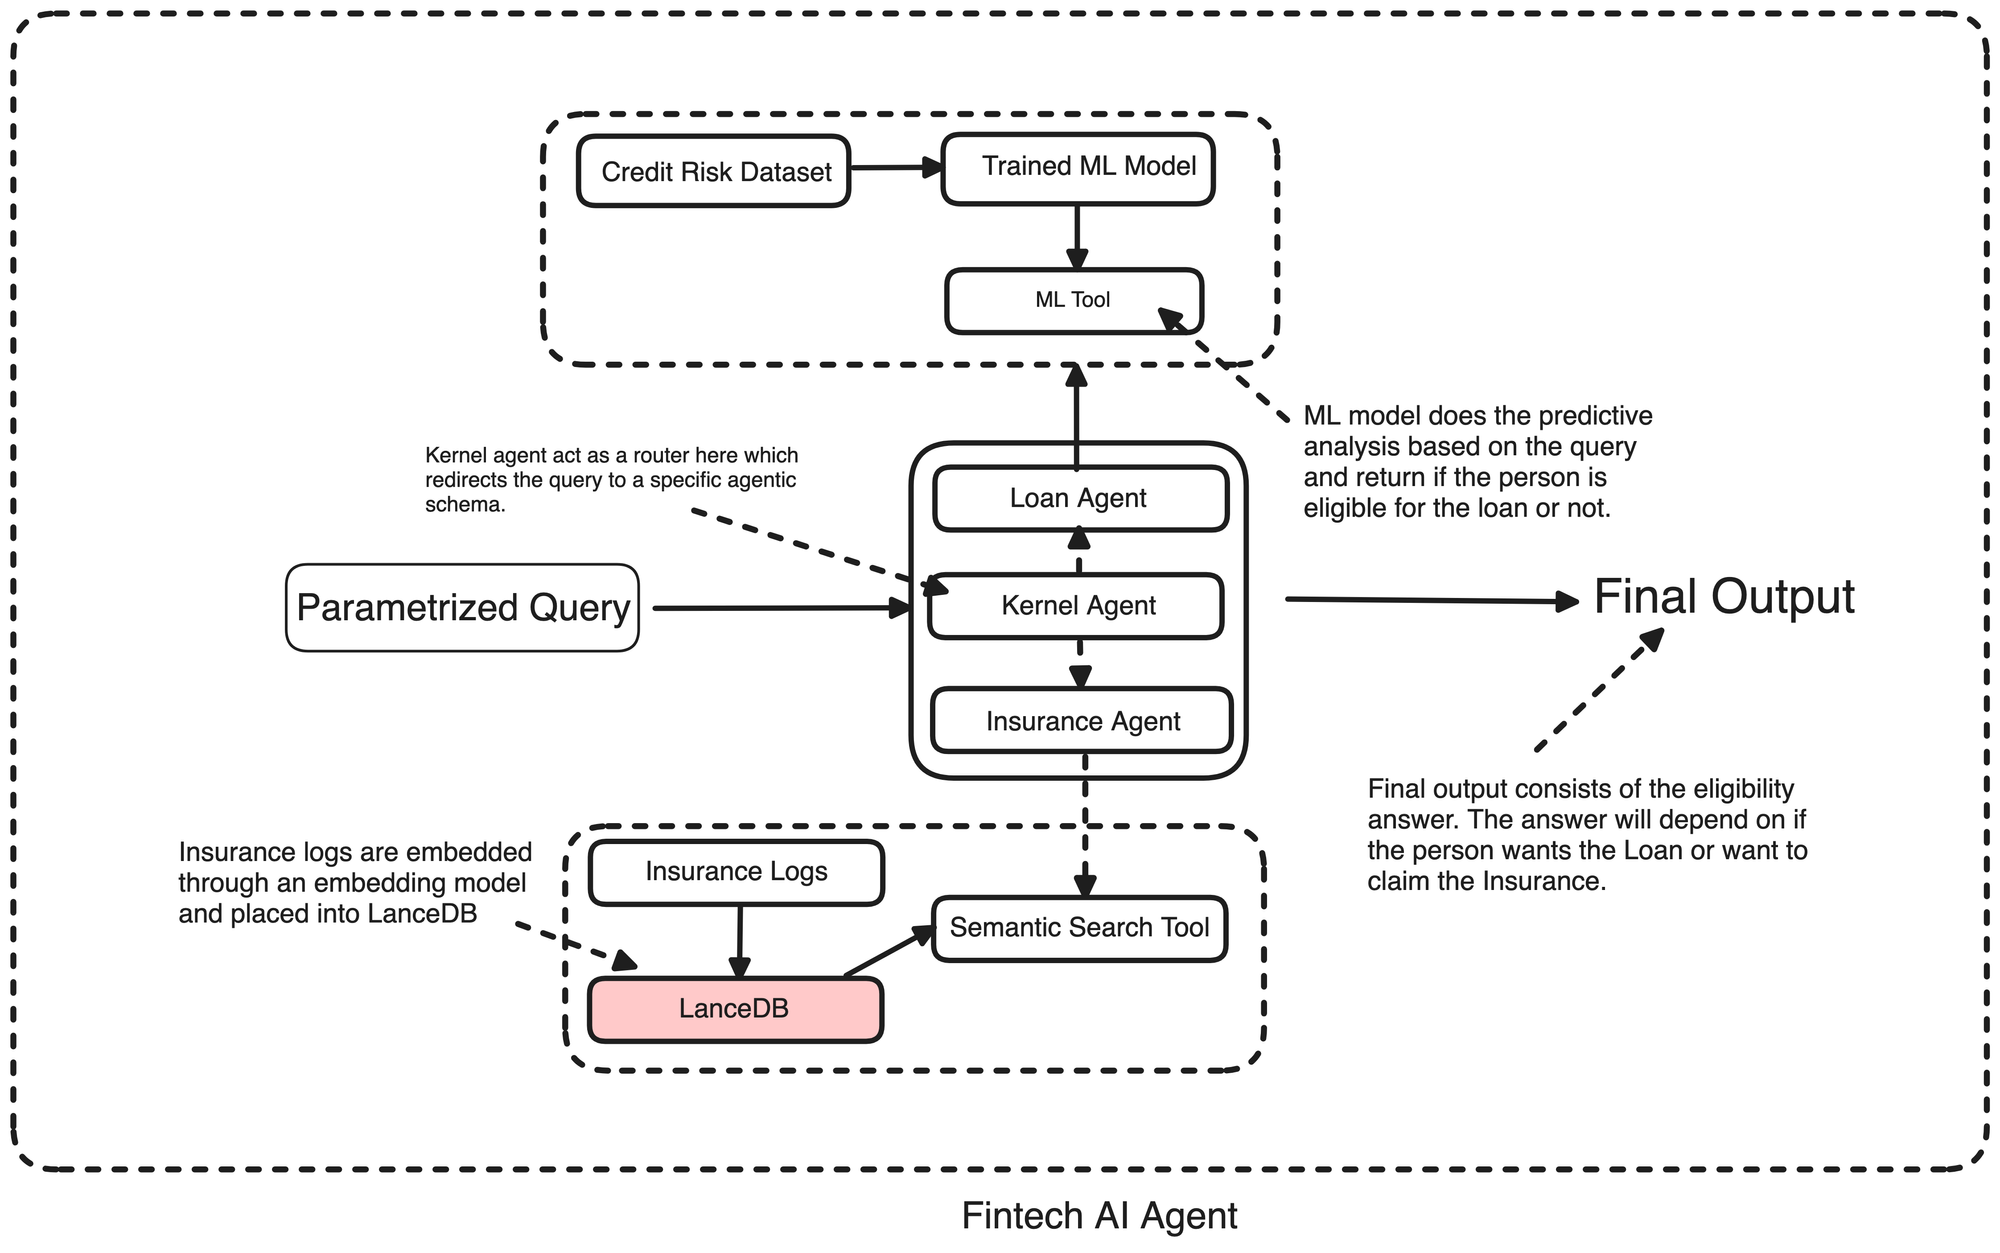

These days, there are tons of frameworks out there to help you whip up AI agents fast. Honestly, it feels like a new “low-code” tool shows up every other day, promising to make building agents a breeze. They’re all over the place—simple drag-and-drop setups or text boxes where you plug in a few prompts and some data, and just like that, your agent’s ready to go.

This time, we will go all in to create a fintech AI agent with no framework, everything is in raw python. This notebook carries an imporant appication of the fintech industry where people face enormus amount of time in processsing loan queries and insurance claims.

In [36]:
%%capture
!pip install pandas joblib pyarrow sentence-transformers lancedb mistralai huggingface_hub

### Setting up the data needs and libraries

In [38]:
import pandas as pd

!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1huZAkbQzTwiELbKbNpghbC2hEBLOqW9V' -O credit_risk_dataset.csv

--2025-02-26 14:08:46--  https://drive.google.com/uc?export=download&id=1huZAkbQzTwiELbKbNpghbC2hEBLOqW9V
Resolving drive.google.com (drive.google.com)... 173.194.217.139, 173.194.217.113, 173.194.217.102, ...
Connecting to drive.google.com (drive.google.com)|173.194.217.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1huZAkbQzTwiELbKbNpghbC2hEBLOqW9V&export=download [following]
--2025-02-26 14:08:46--  https://drive.usercontent.google.com/download?id=1huZAkbQzTwiELbKbNpghbC2hEBLOqW9V&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.217.132, 2607:f8b0:400c:c13::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.217.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1804682 (1.7M) [application/octet-stream]
Saving to: ‘credit_risk_dataset.csv’

credit_risk_dataset 100%[===================>]   

### LLM and Embedding Model Customization

For the language model operations, I’ve implemented Mistral as the foundation, delivering reliable and efficient performance tailored to various tasks. However, the setup is highly flexible—you can seamlessly switch to any other provider or model that better suits your specific needs, ensuring adaptability for your unique use case. The same level of customization applies to the embedding model, allowing you to choose an alternative that aligns perfectly with your project requirements. If you decide to stick with this configuration, just remember to include your `Hugging Face token` and `Mistral API key` to authenticate and unlock the full potential of the system without any hiccups.


In [40]:
import pandas as pd
import joblib
import pyarrow as pa
from sentence_transformers import SentenceTransformer
import lancedb
from mistralai import Mistral
import os
from abc import ABC, abstractmethod
from typing import Any


# Abstract Tool Class
class Tool(ABC):
    @abstractmethod
    def name(self) -> str:
        pass

    @abstractmethod
    def description(self) -> str:
        pass

    @abstractmethod
    def use(self, *args, **kwargs) -> Any:
        pass


# Initialize Mistral
api_key = os.environ.get("MISTRAL_API_KEY", "kER2XXXXXXXXXXX")
if not api_key:
    raise ValueError("Please set the MISTRAL_API_KEY environment variable.")
model = "mistral-large-latest"
client = Mistral(api_key=api_key)
hf_token = "hf_XXXXXXXXXXXXX"

# Initialize Embedder
embedder = SentenceTransformer("all-MiniLM-L6-v2", token=hf_token)

# Connect to LanceDB
db = lancedb.connect("./lancedb_data")

### Predictive ML Modelling

I’m using the [Credit Risk Dataset](https://www.kaggle.com/datasets/laotse/credit-risk-dataset) as a demo for loans. In reality, companies could use something like a CIBIL score to see if someone’s eligible. But for this POC, I grabbed that dataset, trained a random forest model, and used it for predictive analysis.

In [41]:
loan_data = pd.read_csv("./credit_risk_dataset.csv")
loan_data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


### ML Modelling

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Select relevant features and target
features = ["person_age", "person_income", "loan_amnt", "loan_intent"]
target = "loan_status"

# Handle missing values by dropping rows with NaN in these columns
loan_data = loan_data.dropna(subset=features + [target])

# Define preprocessing for categorical feature 'loan_intent'
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), ["loan_intent"])],
    remainder="passthrough",  # Keep numerical features as is
)

# Split data into features (X) and target (y)
X = loan_data[features]
y = loan_data[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Create and train the model pipeline
model_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)
model_pipeline.fit(X_train, y_train)

# Evaluate the model
accuracy = model_pipeline.score(X_test, y_test)
print(f"Model accuracy: {accuracy:.2f}")

Model accuracy: 0.84


In [44]:
import joblib

# Save the trained model
joblib.dump(model_pipeline, "loan_approval_model.pkl")

['loan_approval_model.pkl']

### Setting up the Kernel Agent

The Kernel Agent serves as the intelligent core of the system, designed to comprehend user queries and determine the appropriate actions to direct them to the correct agent—be it the loan agent or the insurance agent—ensuring a smooth and efficient process. It leverages key details provided by the user, such as parameters, along with the detected intent behind the query, to make informed decisions and route requests accurately to the most relevant agent for resolution.

In [45]:
class KernelAgent:
    def __init__(self, loan_agent, insurance_agent):
        self.loan_agent = loan_agent
        self.insurance_agent = insurance_agent
        self.client = client
        self.model = model

    def classify_query(self, query):
        prompt = f"""
        Given the query: '{query}', classify it as 'loan' or 'insurance'.
        Respond with only 'loan' or 'insurance'.
        If unsure, respond with 'unknown'.
        """
        response = self.client.chat.complete(
            model=self.model,
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7,
            max_tokens=10,
        )
        result = response.choices[0].message.content.strip().lower()
        # print(f"Query classified as: {result}")
        return result

    def process_query(self, query, params=None):
        query_type = self.classify_query(query)
        if query_type == "loan":
            if not params:
                return (
                    "Error: Loan query requires parameters (age, income, loan_amount)."
                )
            return self.loan_agent.process(query, params)
        elif query_type == "insurance":
            return self.insurance_agent.process(query)
        else:
            return "Error: Unable to classify query as 'loan' or 'insurance'."

In [46]:
class PredictiveMLTool(Tool):
    def __init__(self):
        self.model = joblib.load("loan_approval_model.pkl")

    def name(self):
        return "Predictive ML Tool"

    def description(self):
        return "Predicts loan eligibility using a trained ML model."

    def use(self, intent, age, income, loan_amount):
        input_data = pd.DataFrame(
            [[age, income, loan_amount, intent]],
            columns=["person_age", "person_income", "loan_amnt", "loan_intent"],
        )
        prob_approved = self.model.predict_proba(input_data)[0][0]
        print(f"Probability for loan approval: {prob_approved:.3f}")
        return "Eligible" if prob_approved > 0.5 else "Not Eligible"


class LoanAgent:
    def __init__(self, client, model):
        self.tools = [PredictiveMLTool()]
        self.client = client
        self.model = model

    def extract_intent(self, query):
        valid_intents = [
            "DEBTCONSOLIDATION",
            "EDUCATION",
            "HOMEIMPROVEMENT",
            "MEDICAL",
            "PERSONAL",
            "VENTURE",
        ]
        prompt = f"""
        Given the query: '{query}', classify the intent into one of:
        {', '.join(valid_intents)}.
        Respond with only the intent in uppercase (e.g., 'HOMEIMPROVEMENT').
        If unsure, respond with 'PERSONAL'.
        """
        response = self.client.chat.complete(
            model=self.model,
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7,
            max_tokens=20,
        )
        intent = response.choices[0].message.content.strip().upper()
        return intent if intent in valid_intents else "PERSONAL"

    def process(self, query, params):
        intent = self.extract_intent(query)
        age = params.get("age")
        income = params.get("income")
        loan_amount = params.get("loan_amount")
        return self.tools[0].use(intent, age, income, loan_amount)

In [51]:
# Test cases for LoanAgent
test_cases = [
    {
        "query": "I need a loan for home renovation",
        "params": {"age": 30, "income": 50000, "loan_amount": 10000},
    },
    {
        "query": "I need a loan for medical expenses",
        "params": {"age": 25, "income": 20000, "loan_amount": 25000},
    },
]

# Initialize LoanAgent
loan_agent = LoanAgent(client, model)

# Run test cases
for case in test_cases:
    query = case["query"]
    params = case["params"]
    result = loan_agent.process(query, params)
    print(f"Query: '{query}' | Params: {params} -> Result: {result}\n")

Probability for loan approval: 0.960
Query: 'I need a loan for home renovation' | Params: {'age': 30, 'income': 50000, 'loan_amount': 10000} -> Result: Eligible

Probability for loan approval: 0.440
Query: 'I need a loan for medical expenses' | Params: {'age': 25, 'income': 20000, 'loan_amount': 25000} -> Result: Not Eligible



### Generating the Demo Insurance Claim dataset

Before diving in, I want to walk you through my thought process for creating the Insurance Agent. Picture this: you walk into an insurance company, sit down with someone, and start explaining why you need to file a claim—why it’s legit and why you deserve it. That conversation is key because it’s the starting point for deciding whether the claim gets processed or not.

I tried hunting down a dataset with those kinds of conversations and clear yes or no labels for claims, but I came up empty. So, to keep things moving, I built a simple synthetic dataset pipeline. It generates a fake dataset with text queries on one side and a target on the other—showing if the person filing the claim is eligible or not.

In [48]:
import random
import csv

# Define base prompt for insurance claims
base_prompt = """
Generate a detailed query for an auto insurance claim. Include specifics about the incident (e.g., cause of the accident, damages, injuries, type of accident, state where it occurred), the user's situation, and what they're claiming. The query should be realistic and reflect what a user might ask an insurance agent. Output only the query text, nothing else.
"""


def generate_query(denied=False):
    prompt = base_prompt
    if denied:
        prompt += " Include a reason the claim might be denied (e.g., drunk driving, uninsured vehicle)."
    response = client.chat.complete(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7,
        max_tokens=200,
    )
    return response.choices[0].message.content.strip()


def assign_target(query):
    rejection_keywords = ["drunk", "influence", "racing", "uninsured"]
    return 0 if any(keyword in query.lower() for keyword in rejection_keywords) else 1


# Generate 10 queries for simplicity (increase to 100 as needed)
dataset = []
print("Generating 10 Auto Insurance Claim Queries:")
print("-" * 50)
for i in range(10):
    denied = random.random() < 0.4
    query = generate_query(denied)
    target = assign_target(query) if not denied else 0
    dataset.append({"query": query, "target": target})
    print(f"{i+1}. Query: {query}")
    print(f"   Target: {target} ({'Approved' if target == 1 else 'Not Approved'})")
    print("-" * 50)

# Save to CSV
with open("auto_insurance_claims.csv", "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["query", "target"])
    writer.writeheader()
    writer.writerows(dataset)

print(f"Total queries generated: {len(dataset)}")
print("Dataset saved to 'auto_insurance_claims.csv'")

Generating 10 Auto Insurance Claim Queries:
--------------------------------------------------
1. Query: Hi, I'm reaching out about an auto insurance claim I need to file. Last night, I was involved in a single-car accident in Massachusetts. I was driving home from work around 8 PM, and it was raining quite heavily. I hydroplaned and lost control of my vehicle, crashing into a guardrail. I was alone in the car, and thankfully, I only have some minor bruises and a slight concussion, but my car is pretty badly damaged. The front end is smashed, and the airbags deployed, so I'm sure the repairs will be costly.

I have comprehensive coverage with a $500 deductible. I'm worried, though, because I had a glass of wine at a work event before driving home. I didn't think I was impaired, but I'm concerned that this could affect my claim. I know I should have called a cab, but I
   Target: 0 (Not Approved)
--------------------------------------------------
2. Query: I was involved in a rear-end c

### Inserting Demo Insurance Queries into LanceDB

The demo insurance queries are added to LanceDB to serve as a foundation for future operations, enabling semantic search capabilities across the existing query dataset. When a new query is introduced, it will be embedded once more, allowing the system to leverage hybrid search techniques to effectively explore and match it against the pre-existing database, ensuring accurate and efficient retrieval of relevant information.

This can become a go-to for the fintech comapaines where they can plug in their own Insurance Conversations logs and do the semantic search on the new embeded queries to retrive the eligibility for the claim.

In [49]:
# Load insurance dataset
df_insurance = pd.read_csv("auto_insurance_claims.csv")

# Generate embeddings
embeddings = embedder.encode(df_insurance["query"].tolist())
embeddings_list = [embedding.tolist() for embedding in embeddings]

# Define schema and create table
schema = pa.schema(
    [
        pa.field("embedding", pa.list_(pa.float32(), list_size=384)),
        pa.field("target", pa.int32()),
        pa.field("query", pa.string()),
    ]
)
table = db.create_table("insurance_queries", schema=schema, mode="overwrite")
df_lance = pd.DataFrame(
    {
        "embedding": embeddings_list,
        "target": df_insurance["target"],
        "query": df_insurance["query"],
    }
)
table.add(df_lance)


# Define SemanticSearchTool
class SemanticSearchTool(Tool):
    def __init__(self, table):
        self.table = table
        self.embedder = embedder

    def name(self):
        return "Semantic Search Tool"

    def description(self):
        return "Performs semantic search in LanceDB to assess claim approval based on similar past claims."

    def use(self, query, k=5):
        new_embedding = self.embedder.encode([query])[0].tolist()
        results = self.table.search(new_embedding).limit(k).to_pandas()
        approval_rate = results["target"].mean()
        similar_queries = results["query"].tolist()
        decision = "Approved" if approval_rate > 0.5 else "Not Approved"
        print(f"Approval rate among similar claims: {approval_rate*100:.1f}%")
        return {"decision": decision, "similar_queries": similar_queries}


# Define InsuranceAgent
class InsuranceAgent:
    def __init__(self, table):
        self.tools = [SemanticSearchTool(table)]

    def process(self, query):
        return self.tools[0].use(query)

### Puttting it all together!

In [53]:
# Initialize Agents
loan_agent = LoanAgent(client, model)
insurance_agent = InsuranceAgent(table)
kernel_agent = KernelAgent(loan_agent, insurance_agent)

# Test cases
test_cases = [
    {
        "query": "I need a loan for home renovation",
        "params": {"age": 30, "income": 50000, "loan_amount": 10000},
    },
    {
        "query": "I had a bad accident yesterday, but I think I was a bit drunk, need some insurance",
        "params": None,
    },
]

# Run tests
print("Testing Integrated System with Mistral:")
print("-" * 50)
for case in test_cases:
    query = case["query"]
    params = case.get("params")
    result = kernel_agent.process_query(query, params)
    print(f"Query: '{query}'")
    if params:
        print(f"Params: {params}")
    if isinstance(result, dict):
        print(f"Decision: {result['decision']}")
        print("Similar Queries:")
        for q in result["similar_queries"]:
            print(f"- {q}")
    else:
        print(f"Result: {result}")
    print("-" * 50)

Testing Integrated System with Mistral:
--------------------------------------------------
Probability for loan approval: 0.960
Query: 'I need a loan for home renovation'
Params: {'age': 30, 'income': 50000, 'loan_amount': 10000}
Result: Eligible
--------------------------------------------------
Approval rate among similar claims: 20.0%
Query: 'I had a bad accident yesterday, but I think I was a bit drunk, need some insurance'
Decision: Not Approved
Similar Queries:
- Hi, I'm reaching out about an auto insurance claim I need to file. Last night, I was involved in a single-car accident in Massachusetts. I was driving home from work around 8 PM, and it was raining quite heavily. I hydroplaned and lost control of my vehicle, crashing into a guardrail. I was alone in the car, and thankfully, I only have some minor bruises and a slight concussion, but my car is pretty badly damaged. The front end is smashed, and the airbags deployed, so I'm sure the repairs will be costly.

I have comprehe